<style>
h3 {
   text-align: center;
}
h1 {
   text-align: center;
}
p {
   text-align: center;
   color: cyan
}
.name{
   color: red
}
</style>

<h1 dir=rtl style="color:green">به نام خدا<br><div class="name"> محمد علی قهاری - 810100201 </div> </h1>

<h3 dir=rtl>هدف : استفاده از genetic algorithms برای حل مساله curve fitting.</h1>
<br>
<p dir=rtl>
در این پروژه ما میخواهیم به صورت بهینه سازی بهترین ضرایب یک چند جمله ای را از روی چند نقطه داده شده بدست آوریم که لزوما جواب یکتایی ندارد!(ورودی نا کافی ممکن است) و این ضرایب صحیح هستند.
<br>
پس هدف ما پیدا کردن چندین جواب خوب است که در عین حال بهترین جواب را هم میخواهیم پس ما سعی میکنیم تعدادی از کروموزوم های خوب نسل فعلی را مستقیم به نسل بعد منتقل کنیم.<br>
روش های مختلف کراس اور و جهش را امتحان میکنیم وجود و عدم وجود وجا به جایی در مراحل الگوریتم را چک میکنیم، <br>در نهایت پارامتر های مطلوب مثل شانس جهش و کراس اور و افزایش تعداد نسل در هر تکرار و... را برای این مساله خاص پیدا کرده و به ازای هر ورودی درست، جواب خوبی در زمان خوبی خواهد داد!
</p>

In [9]:
from sympy import *
import random
import math
import numpy as np
from matplotlib import pyplot as plt

random.seed=27

init_printing(use_latex="mathjax")
%matplotlib inline

<p dir=rtl style="color:cyan;text-align:center">
در این جا ورودی های مساله که شامل ماکسیمم درجه خروجی، محدوده ضرایب و مجموعه نقاط که تابع Fitness بر اساس آن بدست می آید!
</p>

In [10]:
degree=6
interval=(-20,20)
points=[(4, -2243), (5, -5103), (1, -23), (-1, -3), (2, -195)]
# points=[(0,1),(1,0),(2,-5),(-1,-8)]

In [11]:
# ساخت یک ورودی رندوم

NumberOfPoints=20
x=symbols("x")
expr=sum(random.randint(interval[0],interval[1])*x**i for i in range(degree+1))
points=[(j,expr.subs(x,j)) for j in[random.randint(-NumberOfPoints,NumberOfPoints) for i in range(NumberOfPoints)]]
print(points)
expr

[(-1, -27), (-16, 106613583), (6, 232121), (18, 192425741), (6, 232121), (-12, 19292411), (-11, 11511213), (-7, 790341), (5, 74829), (-14, 48197421), (8, 1369431), (9, 2821733), (7, 601845), (2, 285), (0, -1), (6, 232121), (14, 41848113), (-17, 152915781), (-6, 317093), (1, 21)]


   6      5      4       3      2           
6⋅x  - 6⋅x  - 4⋅x  + 19⋅x  - 4⋅x  + 11⋅x - 1

In [12]:
class Chromosome:
    mutationPower=1
    maxMutation=4
    
    def __init__(self,coefficients:list) -> None:
        self.__coefficient=coefficients
    
    def __str__(self) -> str:
        return self.__coefficient.__str__()
    
    def copy(self):
        return Chromosome(self.__coefficient.copy())
    
    def Calculate(self,x:int)->int:
        return sum (i[1]*x**i[0] for i in enumerate(self.__coefficient))
        
    def CrossOver(self,chromosome,edge:int):
        temp=self.__coefficient[edge:]
        self.__coefficient=self.__coefficient[:edge]+chromosome.__coefficient[edge:]
        chromosome.__coefficient=chromosome.__coefficient[:edge]+temp
        return chromosome
    
    def Mutation(self,mutationChance):
        count=0
        while count<self.maxMutation and random.random() < mutationChance:
            count+=1
            i = random.randint(0,len(self.__coefficient)-1)
            self.__coefficient[i] += self.mutationPower if random.random()>.5 else -self.mutationPower
            if self.__coefficient[i]>interval[1] :
                self.__coefficient[i]-=self.mutationPower*2
            if self.__coefficient[i]<interval[0]:
                self.__coefficient[i]+=self.mutationPower*2

<h2  dir=rtl style="color:cyan;text-align:center">
پارامتر های مساله
</h2>

In [13]:
genSize = 1000
MutationChance=.2
CrossOverChance=.4
Pick2RandomChance=.2
maxCrossOver=4
KeepPercent=2
IncGenSizePerIter=0
generation=[Chromosome([random.randint(interval[0],interval[1]+1) for _ in range(degree+1)]) for _ in range(genSize)]

$$\frac{n(n+1)}2 = x \implies{n = \frac{\sqrt{1+8x}-1}2}$$
<p dir=rtl style="color:cyan;text-align:center">
    Fitness function ما مجموع قدر مطلق اختلاف تابع کروموزوم از نقاط ورودی است.<br>
    تابع Pick هم دارای توزیع احتمال تجمعی است یعنی احتمال کروموزوم با رتبه 1 n برابر رتبه n است
    و همیشه به اندازه KeepPercent مستقیم به نسل بعد میرود و توسط کراس اور و جهش، دستکاری نمیشوند!<br>
    خوبی Pick نسبت به Pick2 این است که توزیع پخش تری دارد و شانس بیشتری به کروموزوم های بد میدهد که به خوب تبدیل شوند و
    چند نسل دیگر زنده بمانند!<br>
    برای cross over , mutation نیز یک limit گذاشتم که بیشتر از آن عملیات روی کروموزوم انجام ندهد با این کار حتی با شانس
    یک هم میتوان تست کرد! (تست هم کردم نتیجه این شد که مینیمم خیلی زود تر حاصل شد اما میانگین نوسان زیادی خواهد داشت!)
</p>

In [14]:
def Fitness(chromosome:Chromosome)->int:
    return sum(abs(chromosome.Calculate(i[0])-i[1]) for i in points)

def Sort(list:list[Chromosome])->list[Chromosome]:
    return sorted(list,key=Fitness,reverse=True)

def Mapper(index:int)->int:
    return int((math.sqrt(1 + 8 * index)-1)/2)

def Pick(list:list[Chromosome])->list[Chromosome]:
    maxRange = int(len(list)*(len(list)+1)/2) - 1  
    return [list[Mapper(random.randint(0,maxRange))].copy() for _ in range(len(list)-int(KeepPercent*len(list)/100)+IncGenSizePerIter)]+[i.copy() for i in list[-int(KeepPercent*len(list)/100):]]

def GetRandomIndex(size:int)->int:
    i=size-1
    while random.random()>Pick2RandomChance:
        i-=1
    return i

def Pick2(list:list[Chromosome])->list[Chromosome]:
    size=len(list)-int(KeepPercent*len(list)/100)
    return [list[GetRandomIndex(size)] for _ in range(size+IncGenSizePerIter)]+[i.copy() for i in list[-int(KeepPercent*len(list)/100):]]

def CrossOver(list:list[Chromosome]):
    for i in range(0,len(list)-int(KeepPercent*len(list)/50),2):        
        count=0
        while count<maxCrossOver and random.random() < CrossOverChance:            
            count+=1
            list[i+1] = list[i].CrossOver(list[i+1],random.randint(1,degree-1))

def Mutation(list:list[Chromosome]):
    for i in list[:-int(KeepPercent*len(list)/100)]:
        i.Mutation(MutationChance)

def GetBest(list:list[Chromosome])->Chromosome:
    return min(list,key=Fitness)

def GetAvarage(list:list[Chromosome])->float:
    return sum(map(Fitness,list))/len(list)

<p dir=rtl style="color:cyan;text-align:center">
چون ما همیشه یه درصدی از کروموزوم های برتر را مستقیما منتقل میکنیم، مینیمم همیشه در حال کاهش است!<br>
یکی از دلایلی که کراس اور قبل از جهش هست این است که چون بعد از Pick احتمالا کروموزوم های خوب کنار هم باشند بیشتر است و کراس اور روی این ها تاثیری نمیگذارد اما اگر اول جهش صورت گیرد این ها تغییر کرده و کراس اور میتواند وضعیت را بدتر کند!
</p>

In [15]:
def Process(list:list[Chromosome])->list[Chromosome]:
    best=Fitness(GetBest(list))
    CrossOver(list)
    newBest=Fitness(GetBest(list))
    if best>newBest:
        print(str(best)+" (cross over)-> "+str(newBest))
    best=newBest
    Mutation(list)
    newBest=Fitness(GetBest(list))
    if best>newBest:
        print(str(best)+" (mutation)-> "+str(newBest))
    list=Sort(list)
    list=Pick(list)
    return list

4893462 (cross over)-> 4893450
1 -> 4893450 : 191991181351/500
4893450 (cross over)-> 4638580
4638580 (mutation)-> 3221058
2 -> 3221058 : 26704602209/125
3221058 (mutation)-> 3204888
3 -> 3204888 : 2732483146/25
3204888 (cross over)-> 3170902
4 -> 3170902 : 5476377809/100
3170902 (cross over)-> 1051388
5 -> 1051388 : 3299848939/125
1051388 (cross over)-> 1010740
6 -> 1010740 : 329236393/25
1010740 (cross over)-> 681054
681054 (mutation)-> 424972
7 -> 424972 : 345061591/50
424972 (cross over)-> 422904
8 -> 422904 : 215353083/50
422904 (cross over)-> 417398
9 -> 417398 : 438985774/125
417398 (cross over)-> 400442
10 -> 400442 : 1253705191/500
400442 (mutation)-> 359022
11 -> 359022 : 445967331/250
359022 (cross over)-> 33370
12 -> 33370 : 678867729/500
13 -> 33370 : 107061896/125
33370 (mutation)-> 32266
14 -> 32266 : 330720773/500
15 -> 32266 : 199992083/250
32266 (cross over)-> 24908
16 -> 24908 : 90138103/250
17 -> 24908 : 196723623/500
24908 (cross over)-> 21864
21864 (mutation)-> 21

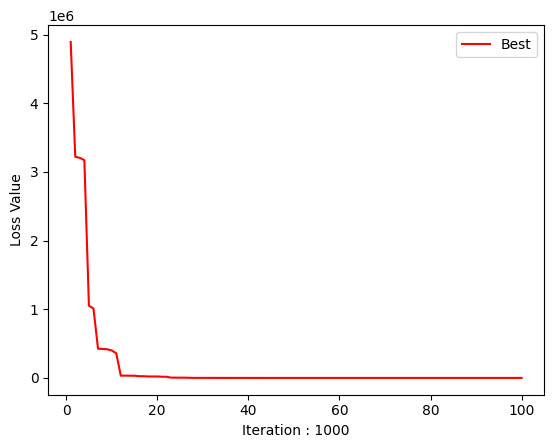

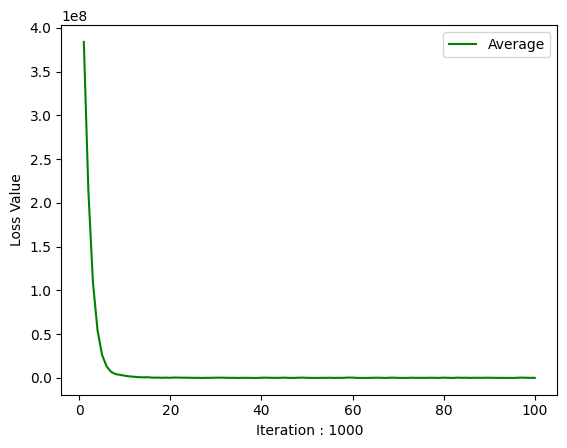

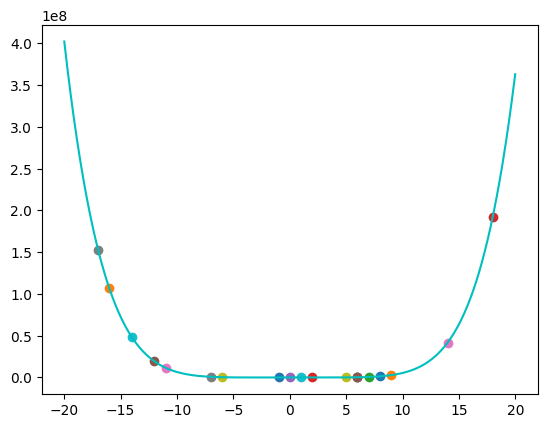

In [16]:
i=0
generation=Sort(generation)
generation=Pick(generation)
iList=[]
bestList=[]
aveList=[]
while(i<100):
    generation=Process(generation)    
    i+=1 
    iList.append(i)
    bestList.append(int(Fitness(GetBest(generation))))
    aveList.append(GetAvarage(generation))
    if(len(generation)!=genSize):
        print('bug')
    print(str(i)+" -> "+str(Fitness(GetBest(generation)))+" : "+str(GetAvarage(generation)))
plt.plot(iList,bestList,color='r',label='Best')
plt.xlabel('Iteration : '+str(genSize))
plt.ylabel('Loss Value')
plt.legend()
plt.show()
plt.plot(iList,aveList,color='g',label='Average')
plt.xlabel('Iteration : '+str(genSize))
plt.ylabel('Loss Value')
plt.legend()
plt.show()
x=np.arange(interval[0],interval[1],.01)
best=GetBest(generation)
plt.plot(x,list(map(best.Calculate,x)),color='c',label='Function')
for i in points:
    plt.scatter(i[0],i[1])
plt.show()

<br>no cross over<br>
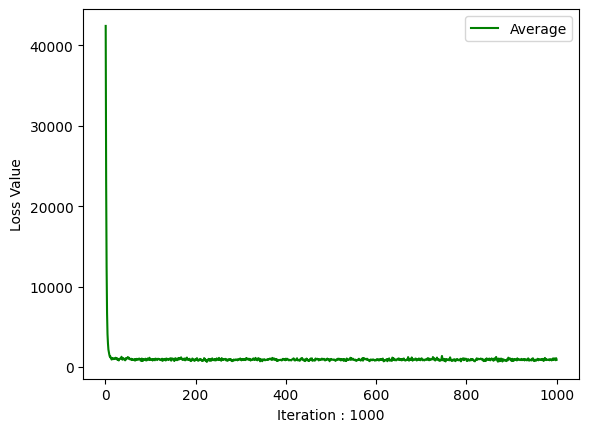
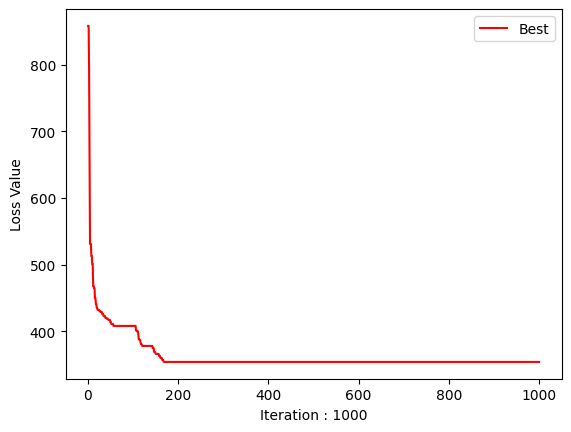
<br>no mutation<br>
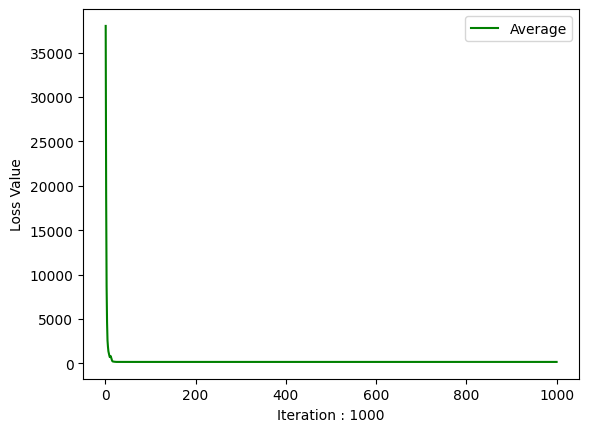
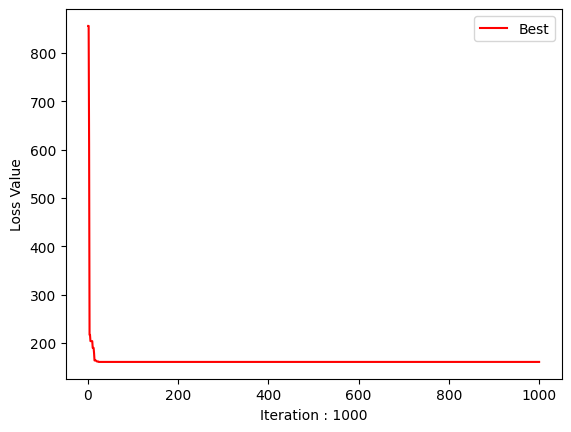
<br>inverse cross over & mutation<br>
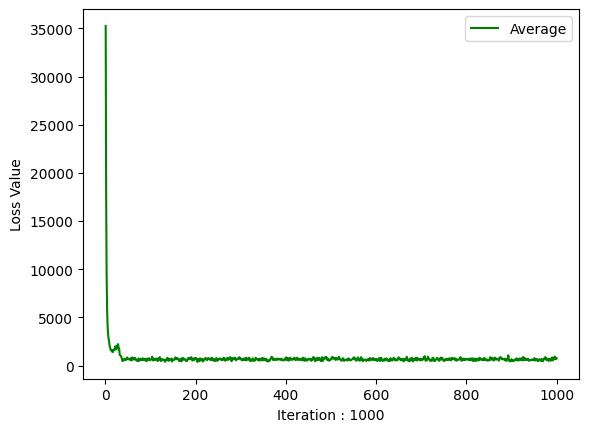
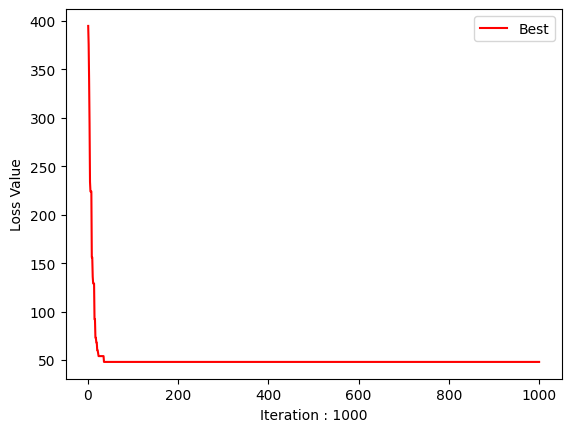
<br>normal<br>
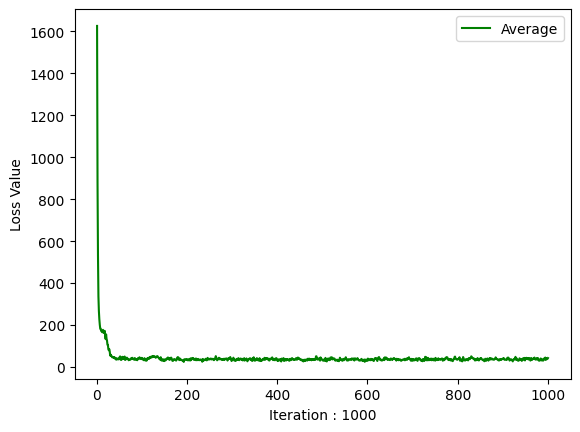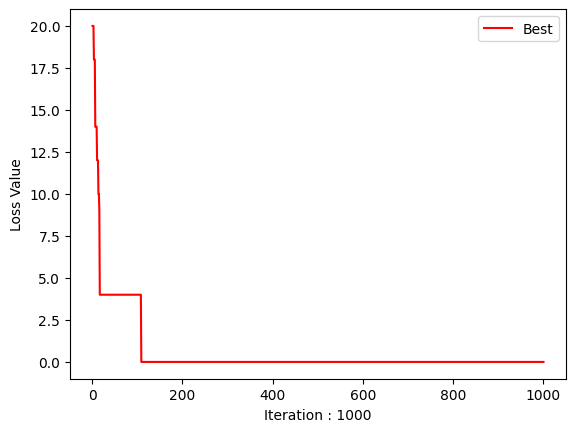

این ها نشان دهنده نمایی از خروجی تابع ژنتیک برای مینیمم و میانگین است!(درجه 30 و بازه 20 تا -20 و نسل 10000 تایی)<br>
درجه و بازه بزرگ زمان اجرا و خطا را زیاد میکند!
<br><br>
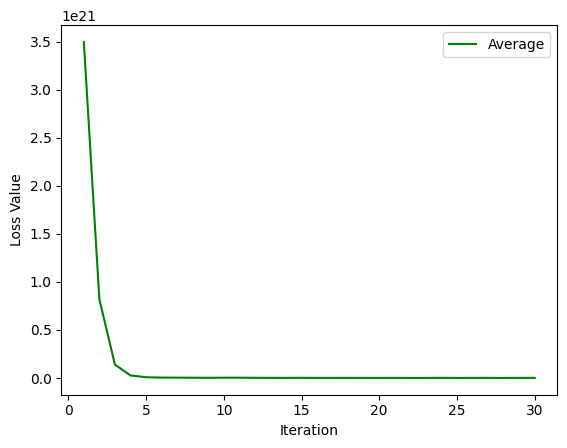
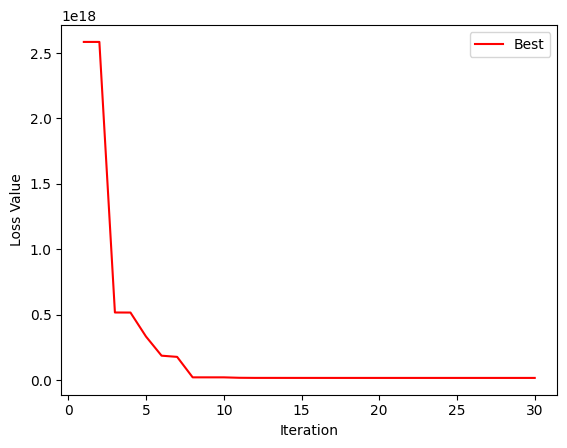
<br><br>
برای نسل کوچک (مینیمم به 0 نرسید!)
<br><br>
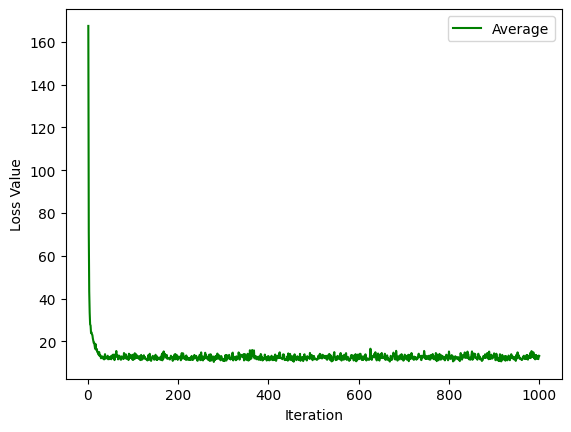
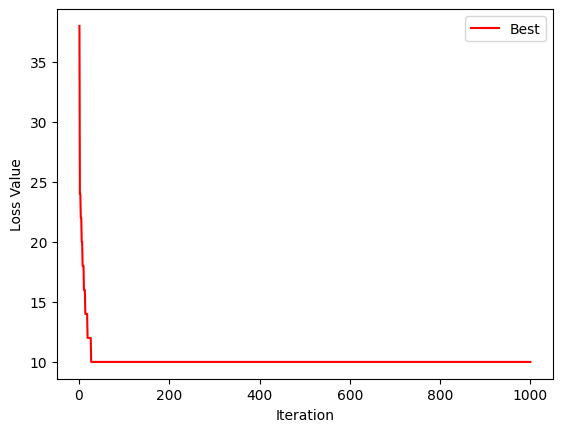
<br><br>
برای نسل بزرگ (مینیمم در تکرار 5 به 0 رسید اما زمان اجرا 1000 برابر کند تر بود!)
<br><br>
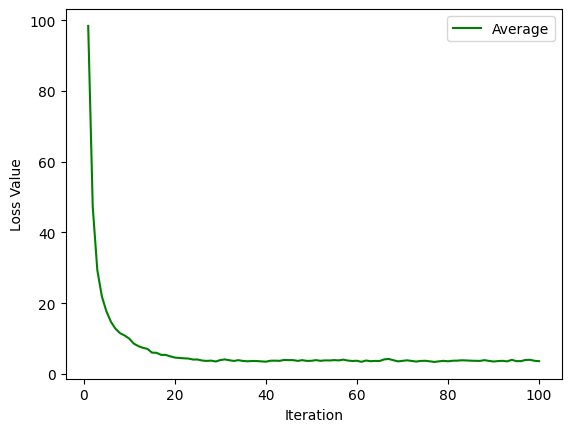
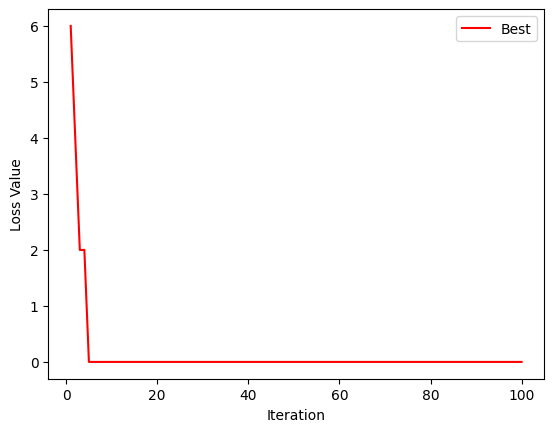
<br><br>
توضیحات در پایین
<br><br>
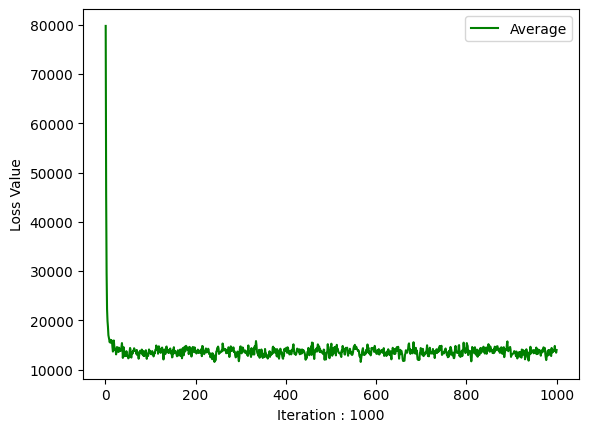
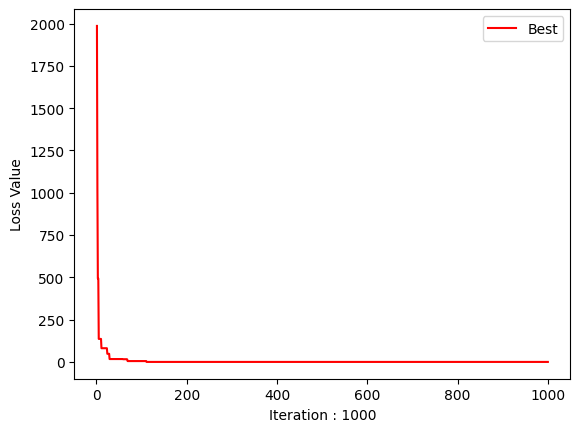
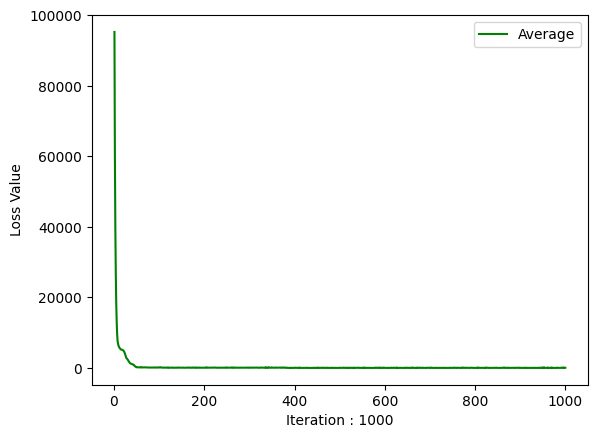
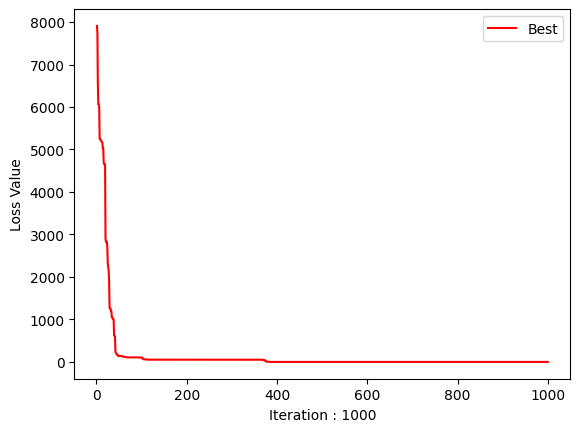
<p dir=rtl style="color:cyan;text-align:center">
مقایسه mutation , cross over با شانس بالا و پایین:<br>
بالایی شانس 1 و پایینی شانس 0.1<br>
شانس زیاد تناوب میانگین را زیاد میکند ولی مینیمم زود تر به 0 میرسد.<br>
شانس کم تناوب میانگین کمتر(همگرایی بیشتر) ولی دیر تر به 0 میرسد!
</p>

<h3 style="color:green;text-align:center" dir=rtl>
پاسخ به سوالات آخر
</h3>
<div style="text-align:right" dir=rtl>
<b>سوال 1:</b><br>
اگر جمعیت زیاد باشد میزان محاسبات ما زیاد میشود و ممگن است منابع ما مناسب نباشد همچنین زمان بیشتر میشود، اما در تکرار های کمتری به نتیجه بهتری میرسد چون واضحا با احتمال بیشتری بهینه ترین جواب در نسل اولیه ما خواهد بود!<br>
از طرف دیگر اگر کم باشد تعداد تکرار های زیادی لازم است تا بلاخره در یک جهش یا کراس اور طلایی یک کروموزوم خوب ساخته شود و در نسل بعدی هم باقی بماند.<br>
در این بین یک حالت بهینه وجود دارد که نسل ما زود تر به میانگین بهینه برسد!(در زمان کمتر)
<br><b>سوال 2:</b><br>
به مرور زمان سرعت هر تکرار کم و دقت آن زیاد میشود.<br>
با این کار به مرور تغییرات میانگین کمتر میشود چون تعداد زیاد تر میشود و جهش یا کراس اور یک کروموزوم تاثیر زیادی رو کل نمیگذارد.<br>
در کل برای همگرا شدن ایده خوبی هست، اما من چند بار امتحان کردم با اندازه اولیه یکسان این روش معمولا میانگین بدتری نسبت به روش معمولی دارد!
<br><b>سوال 3:</b><br>
کراس اور، یک نسل که تفاوت کروموزوم های آن زیاد است، را زیاد تغییر میدهد. یعنی این عملیات به نسبت تفاوت دو کروموزوم میتواند آن ها را تغییر دهد.<br>
از آن طرف جهش وضعیت نسل برایش فرقی نمیکند. که یعنی اوایل تاثیر کراس اور بیشتر است در پیشرفت و در اواخر کار که تقریبا کروموزوم ها یکسان هستند این جهش هست که یک فرجی باید حاصل کند تا به جواب بهتری برسیم!<br>
پس با حذف هر کدام داریم به وضع بدتری میرسیم : با حذف کراس اور سرعت و با حذف جهش شانس رسیدن به جواب بهتر را کاهش میدهیم که در کل توصیه نمیشود!
<br><b>سوال 4:</b><br>
در حالت کلی میتوان با تغییر پارامتر های مساله مثل نحوه کراس اور و جهش و اندازه نسل اولیه و ... به صورت تجربی به یک حالت اپتیمال رسید!<br>
در حالت های خاص هم میتوان به صورت الگوریتمیک بعضی از ضرایب را بدست اورد و دیگر در تمام کروموزوم ها به آن ها دست نزد! مثل w0 که اگر در x=0 به ما نقطه دهند میتوان آن را به صورت قطعی حدس زد!
<br><b>سوال 5:</b><br>
یکی از مشکلات آن میتواند این باشد که فکر کنیم که ما به همگرایی رسیدیم و الگوریتم را متوقف و خروجی دهیم وحال اینکه در لوکال ماکسیمم افتاده باشیم!<br>
راه حل آن نیز مشابه مبحث لوکال ماکسیمم این است که الگوریتم را چند بار اجرا کنیم با چند نسل اولیه رندوم که احتمال اینکه همه شان در یک لوکال ماکسیمم بیوفتند پایین است! و در آخر بهترین آن ها را خروجی میدهیم.
<br><b>سوال 6:</b><br>
یک راه آن این است که به مینیمم نگاه کنیم و ببینیم که اگر به صفر نمیرسد(کاری به میانگین نداریم!) الگوریتم را متوقف کنیم و بگوییم که جواب ندارد.<br>
البته مشابه سوال قبل باید این کار را چند بار انجام دهیم تا مطمان باشیم در لوکال ماکس نمیافتیم!
<br><b>سوال 7:</b><br>
هر درجه یک ژن در کروموزوم است پس در هر عملیات کراس اور و جهش یک واحد به کارشان اضافه میشود پس میتوان گفت خطی رابطه دارد!<br>
البته افزایش درجه سبب میشود تابع Fitness به صورت توانی افزایش یابد، که باعث میشود یک تغییر کو چک در mutation , cross over زیاد تغییر کند و نیاز به تکرار های بیشتری داشته باشد! <br>
چون تعداد حالات با افزایش هر درجه k برابر(k درجه فعلی است) میشود پس به هر حال محدوده آن نمایی میشود که به صورت میانگین زمان به جواب رسیدن (نه یک تکرار) نمایی افزایش میابد!
<br><b>سوال 8:</b><br>
افزایش آن به قطع دقت الگوریتم را افزایش میدهد اما تعداد جواب ها را نیز محدود تر میکند که نتیجه آن سخت تر به مینیمم رسیدن نسل میشود، همچنین میانیگین آن.<br>
کاهش آن نیز اثر معکوس دارد!<br>
برای محاسبه تابع Fitness خطی افزایش میابد.
</div>